In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

#### Hyperparameter 설정

28 x 28의 input size 사용, 256개의 노드를 가진 중간층 사용

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

#### 인코더 정의

- 이전 출력을 매개변수로 사용하여 각 층을 호출
- h층은 x층을 입력으로 받음
- 모델을 컴파일하고 시작 지점(x)과 끝나는 지점([z_mean, z_log_var, z]) 정의
- z : 잠재 공간, 평균과 분산에 의해 정의되는 정규분포에 해당

In [3]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

하나의  z가 샘플링 함수를 통해 z_mean, z_log_var와 연결되어 있고, 이는 평균과 표준편차를 학습하는 것을 의미한다.

In [4]:
#encoder 입력
x = Input(shape=(original_dim,), name="input")
#중간층
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
#잠재 공간의 평균 정의
z_mean = Dense(latent_dim, name="mean")(h)
#잠재 공간의 로그 분산 정의
z_log_var = Dense(latent_dim, name="log-variance")(h)

z_mean과 z_log_var는 노드가 2개인 Dense층에 연결되어 있고, 이 노드는 정규분포의 특징을 정의하는 평균과 분산을 의미한다.

In [5]:
#텐서플로 백엔드를 사용할 때는 output shape이 필수는 아니다.
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
#케라스 모델로 인코더 정의
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

In [6]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

#### 디코더 정의

In [7]:
#디코더 입력
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
#잠재 공간을 중간층의 차원으로 변환
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
#원본 차원으로 변환
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
#케라스 모델로 디코더 정의
decoder = Model(input_decoder, x_decoded, name="decoder")

In [8]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


#### 모델 결합

In [9]:
#인코더의 출력을 디코더의 입력으로 사용, 3번째 반환값이 z
output_combined = decoder(encoder(x)[2])
#입력과 출력 연결
vae = Model(x, output_combined)
#모델 구조 출력
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


#### 손실 함수 정의

In [10]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
______________________________________________________________________________________________

이진 교차 엔트로피(binary crossentropy)와 클벡-라이블러 발산(Kullback-Leibler divergence)을 더해서 전체 손실을 만든다.
- KL 발산 : 분포간의 부피를 계산한 다음 겹치는 부분의 부피 측정
    - 두 분포 간의 교차 엔트로피와 자기 자신의 엔트로피 간의 차이 측정
- 이진 교차 엔트로피 : 클래스가 두 개인 분류 문제에서 사용하는 전형적인 손실 함수 중 하나

input x와 output x_decoded_mean값과 각각 비교

optimizer는 일반적으로 Adam, SGD(Stochastic Gradient Descent), RMSprop 사용

#### 데이터 분할

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

데이터를 정규화하고, train과 test 데이터룰 28x28이 아니라 784 크기의 배열을 가지도록 변환

#### 모델 학습

In [12]:
vae.fit(x_train, x_train, shuffle = True, epochs = epochs, batch_size = batch_size)

Epoch 1/50
600/600 [==============================] - 7s 8ms/step - loss: 0.2865
Epoch 2/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2183
Epoch 3/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2132
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2103
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2080
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2061
Epoch 7/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2036
Epoch 8/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2024
Epoch 9/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2016
Epoch 10/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2005
Epoch 11/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2000
Epoch 12/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1987
Epoch 13/50
600/600 [====

In [14]:
import matplotlib.pyplot as plt

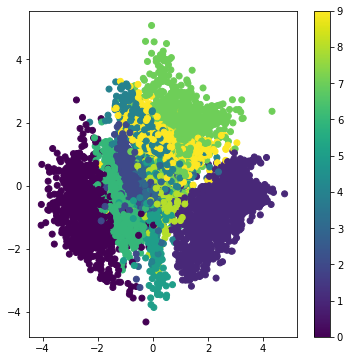

In [15]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

테스트 세트의 모든 포인트를 잠재 공간으로 이차원 투영. 2차원 잠재 공간에서 클래스별로 잘 무리지어 있음을 확인할 수 있다.

In [17]:
from scipy.stats import norm

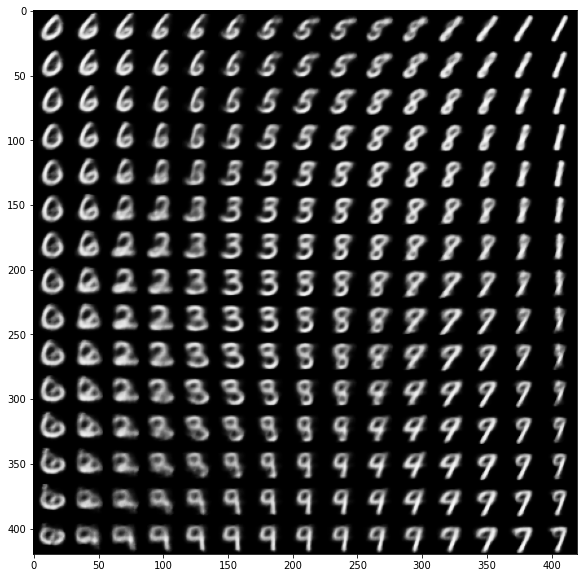

In [18]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

일정한 간격으로 나눈 잠재공간을 디코더로 전달에 output 생성